In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
%load_ext autoreload
%autoreload 2
import model.dataset as ds
import model.models
import scipy.spatial.distance as ssdist
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.io.wavfile
from scipy.fftpack import dct
import scipy.signal
import IPython.display

In [2]:
torch.cuda.empty_cache()

### Loading the dataset

set up dataloader

In [3]:
path = '/usr0/home/tianjunm/datasets/processed/mixer/5-10-2000-4/test';
d = ds.SignalDataset(root_dir=path, transform=ds.Concat(size=(129, 690), encdec=True))
# d = ds.SignalDataset(root_dir=new, transform=ds.ToTensor(size=(129, 690)))

In [4]:
dataloader = torch.utils.data.DataLoader(d, batch_size=2, shuffle=False)

In [5]:
for i, info in enumerate(dataloader):
    aggregate = info['aggregate']
    ground_truths_in = info['ground_truths_in']
    ground_truths_gt = info['ground_truths_gt']
    
    break

_, seq_len, input_dim = aggregate.shape
print(aggregate.shape)
print(ground_truths_in.shape)
print(ground_truths_gt.shape)

torch.Size([2, 690, 258])
torch.Size([2, 691, 1290])
torch.Size([2, 690, 5, 258])


In [6]:
def display(spect, sample_rate, y_axis='mel',x_axis='time'):
    db_data = librosa.power_to_db(np.abs(spect)**2, ref=np.max)
    librosa.display.specshow(db_data, sr=sample_rate, y_axis=y_axis, x_axis=x_axis)
    
def get_spect(data):
    r = np.split(data.numpy().T, 2)[0]
    i = np.split(data.numpy().T, 2)[1]
    c = r + 1j * i
    return c, scipy.signal.istft(c, fs=44100, nfft = 256)

visualize sample data

In [ ]:
def get_gt_spect(ground_truths_gt, nsource):
    for i in range(nsource):
        

In [15]:
nsource = 5

agg_sample = aggregate[0]
c_agg, (fs, data) = get_spect(agg_sample)

gt_1 = ground_truths_gt[0, :, 0, :]
gt_2 = ground_truths_gt[0, :, 1, :]
gt_3 = ground_truths_gt[0, :, 2, :]
gt_4 = ground_truths_gt[0, :, 3, :]
gt_5 = ground_truths_gt[0, :, 4, :]
c_gt1, _ = get_spect(gt_1)
c_gt2, _ = get_spect(gt_2)
c_gt3, _ = get_spect(gt_3)
c_gt4, _ = get_spect(gt_4)
c_gt5, _ = get_spect(gt_5)

gin_1 = ground_truths_in.view(-1, seq_len+1, nsource, input_dim)[0, :, 0, :]
gin_2 = ground_truths_in.view(-1, seq_len+1, nsource, input_dim)[0, :, 1, :]
gin_3 = ground_truths_in.view(-1, seq_len+1, nsource, input_dim)[0, :, 2, :]
gin_4 = ground_truths_in.view(-1, seq_len+1, nsource, input_dim)[0, :, 3, :]
gin_5 = ground_truths_in.view(-1, seq_len+1, nsource, input_dim)[0, :, 4, :]
c_gin1, _ = get_spect(gin_1)
c_gin2, _ = get_spect(gin_2)
c_gin2, _ = get_spect(gin_3)
c_gin2, _ = get_spect(gin_4)
c_gin2, _ = get_spect(gin_5)


# print(np.array_equal())

True


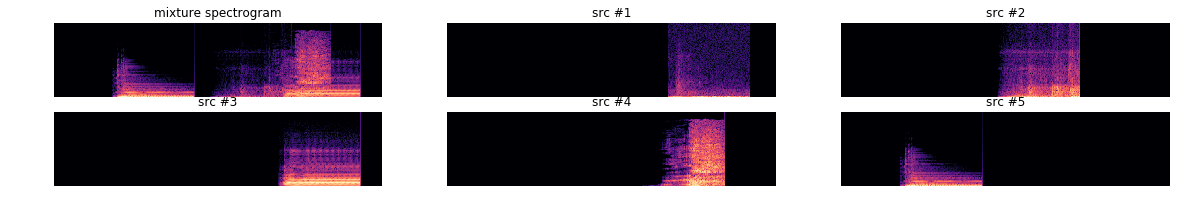

In [49]:
fig = plt.figure(figsize=(20, 3))
plt.subplot(2, 3, 1)
plt.title('mixture spectrogram')
plt.axis('off')
display(c_agg, 22050*8)
plt.subplot(2, 3, 2)
plt.title('src #1')
# plt.plot(data)
plt.axis('off')
display(c_gt1, 22050*8)
plt.subplot(2, 3, 3)
plt.title('src #2')
plt.axis('off')
display(c_gt2, 22050*8)
plt.subplot(2, 3, 4)
plt.title('src #3')
plt.axis('off')
display(c_gt3, 22050*8)
plt.subplot(2, 3, 5)
plt.title('src #4')
plt.axis('off')
display(c_gt4, 22050*8)
plt.subplot(2, 3, 6)
plt.title('src #5')
plt.axis('off')
display(c_gt5, 22050*8)

print(np.array_equal(gin_1[1:], gt_1))

In [26]:
import scipy.io.wavfile
from scipy.fftpack import dct
import scipy.signal
import IPython.display
import librosa
import librosa.display
import matplotlib.pyplot as plt

# _, rdata = scipy.signal.istft(c, fs=44100, nfft = 256)
# IPython.display.Audio(data=rdata, rate=44100)

transformer model

In [28]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)

cuda:3


In [60]:
import model.transformer
_, seq_len, freq_range = aggregate.shape
print(seq_len)
print(freq_range)
net = model.transformer.make_model(freq_range, num_sources=5).to(device)
net.load_state_dict(torch.load('pretrained/transformer_checkpoint_euclidean_5-10_0(200).pth'))
# net.eval()

690
258


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [31]:
from torch.autograd import Variable
subseq_mask = model.transformer.subsequent_mask(ground_truths_in.shape[1])
subseq_mask = Variable(subseq_mask).type_as(aggregate.data).to(device)

In [32]:
print(subseq_mask.shape)
# plt.figure(figsize=(5,5))
# plt.imshow(subseq_mask.cpu()[0])

torch.Size([1, 691, 691])


aggregate

In [45]:
_, data = scipy.signal.istft(c_agg, fs=44100, nfft = 256)
IPython.display.Audio(data=data, rate=44100)

predicted separations

In [50]:
_, rdata = scipy.signal.istft(c_gt1, fs=44100, nfft = 256)
IPython.display.Audio(data=rdata, rate=44100)

In [51]:
_, rdata = scipy.signal.istft(cs[0], fs=44100, nfft = 256)
IPython.display.Audio(data=rdata, rate=44100)

In [53]:
_, rdata = scipy.signal.istft(cs[1], fs=44100, nfft = 256)
IPython.display.Audio(data=rdata, rate=44100)

In [69]:
_, rdata = scipy.signal.istft(cs[2], fs=44100, nfft = 256)
IPython.display.Audio(data=rdata, rate=44100)

In [70]:
_, rdata = scipy.signal.istft(cs[3], fs=44100, nfft = 256)
IPython.display.Audio(data=rdata, rate=44100)

In [71]:
_, rdata = scipy.signal.istft(cs[4], fs=44100, nfft = 256)
IPython.display.Audio(data=rdata, rate=44100)

### Greedy decoding

In [64]:
seps = model.transformer.greedy_decoder(net, aggregate.to(device), seq_len, 5, freq_range, device)

In [65]:
print(seps.shape)
pp = seps.view(-1, seq_len, 5, 258)

torch.Size([2, 690, 1290])


In [66]:
def get_pred_spect(pp, num_sources, xid=0):
    cs = []
    for i in range(num_sources):
        g = pp[xid, :, i, :].cpu().numpy().T
        r = np.split(g, 2)[0]
        i = np.split(g, 2)[1]
        c = r + 1j * i
        cs.append(c)
    return cs

def plot_cs(cs, dim):
    fig = plt.figure(figsize=(20, 3))
    cs = [c_agg] + cs
    for i, c in enumerate(cs):
        plt.subplot(dim[0], dim[1], i + 1)
        display(c, 22050*8)
        plt.axis('off')

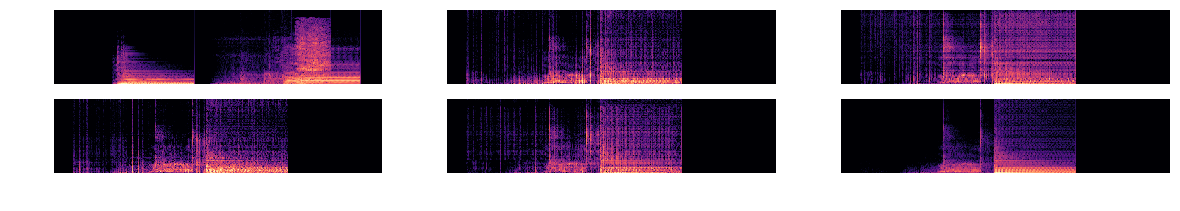

In [72]:
cs = get_pred_spect(pp, 5, xid=1)
plot_cs(cs, dim=(2, 3))

### random experiments

In [ ]:
a = torch.arange(12).view(4, 3)
a1 = a[:2].view(-1, 3)
a2 = a[2:].view(-1, 3)

print(a1)
print(a2)

print(torch.cat([a1, a2]))
print(torch.cat([a1, a2]).shape)
# print(a.sha)

In [ ]:
aa = torch.arange(12.).view(3, 4)
a = aa.view(4, 3)
# b = torch.ones(4, 3).copy_(a)
b = torch.cat([torch.ones(3).view(1,3), a])

print(aa)
print(a)
print(b)
aa.fill_(10)
print(a)
print(b)


In [ ]:
torch.ones(2, 3)
torch.zeros(2, 3)

In [ ]:

def check(m_c, m):
    for i in range(m_c.shape[0]):
        for j in range(m_c.shape[1]):
            batch = i // m.shape[1]
            ii = i % m.shape[1]
            assert(m_c[i][j] == m[batch][ii][j])
    print("passed")

check(agg_concat, agg)